In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

insurance_df = pd.read_csv("../Data/insurance.csv")

insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### EDA

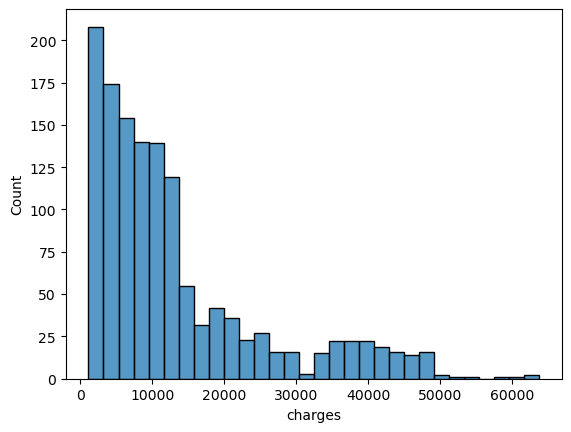

In [13]:
sns.histplot(insurance_df["charges"]);

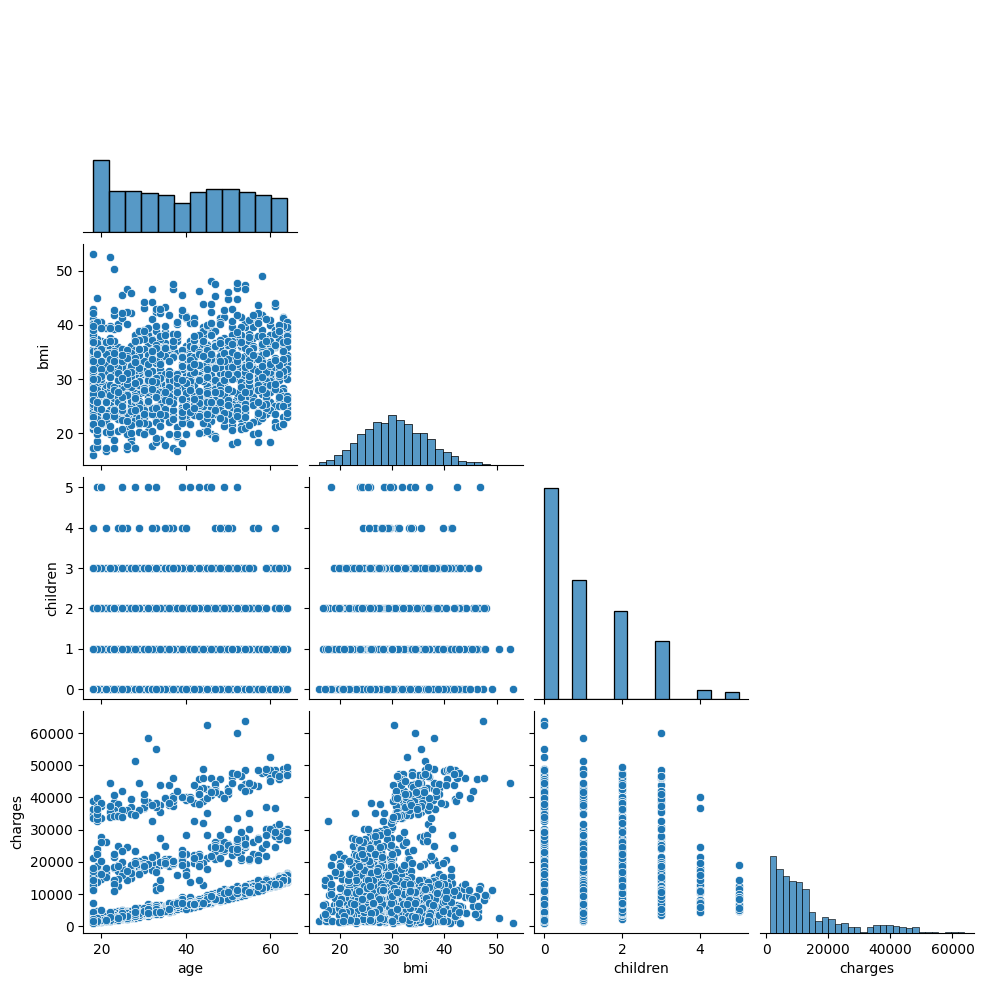

In [5]:
sns.pairplot(insurance_df, corner=True)

In [15]:
insurance_df.corr(numeric_only=True)

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


<Axes: >

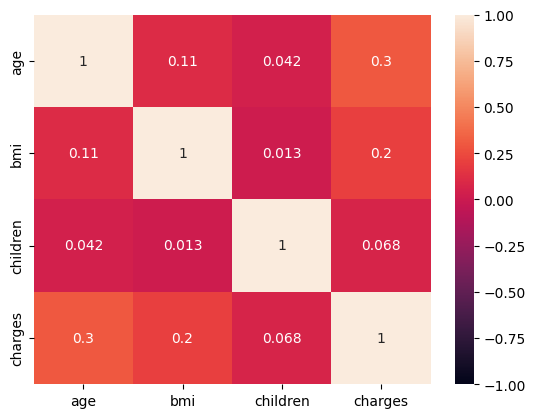

In [6]:
sns.heatmap(insurance_df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1)

### Fitting the Model

In [12]:
X = sm.add_constant(insurance_df["age"])
y = insurance_df["charges"]

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     131.2
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           4.89e-29
Time:                        16:50:29   Log-Likelihood:                -14415.
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1336   BIC:                         2.884e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3165.8850    937.149      3.378      0.001    1327.440    5004.330
age          257.7226     22.502     11.453      0.000     213.579     301.866
==============================================================================
Omnibus:                      399.600   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              864.239
Skew:                           1.733   Prob(JB):                    2.15e-188
Kurtosis:                       4.869   Cond. No.                         124.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Making Predictions

In [13]:
customer_ages = [18, 25, 35, 45, 55]

X_predict = sm.add_constant(pd.DataFrame({"age": customer_ages}))

X_predict

,const,age
0,1.0,18
1,1.0,25
2,1.0,35
3,1.0,45
4,1.0,55


In [14]:
predictions = model.predict(X_predict)

predictions 

0     7804.892142
1     9608.950473
2    12186.176659
3    14763.402846
4    17340.629033
dtype: float64

In [19]:
predictions.name = "predictions"
predictions

0     7804.892142
1     9608.950473
2    12186.176659
3    14763.402846
4    17340.629033
Name: predictions, dtype: float64

In [22]:
(insurance_df
 .query("age in @customer_ages")
 .groupby("age")
 .agg({"charges": "mean"})

)

,charges
age,
18,7086.217556
25,9838.365311
35,11307.182031
45,14830.199856
55,16164.545488


In [23]:
(insurance_df
 .query("age in @customer_ages")
 .groupby("age")
 .agg({"charges": "mean"})
 .reset_index()
 .merge(predictions, left_index=True, right_index=True)
)

,age,charges,predictions
0,18,7086.217556,7804.892142
1,25,9838.365311,9608.950473
2,35,11307.182031,12186.176659
3,45,14830.199856,14763.402846
4,55,16164.545488,17340.629033


In [10]:
## Compare predictiosn to actual values

(insurance_df
 .query("age in @customer_ages")
 .groupby("age")
 .agg({"charges": "mean"})
 .reset_index()
 .merge(predictions, left_index=True, right_index=True)
 .assign(
     error = lambda x: x["predictions"] - x["charges"],
     pct_difference = lambda x: (x["error"] / x["charges"]) * 100
 
 )
)

,age,charges,predictions,error,pct_difference
0,18,7086.217556,7804.892142,718.674586,10.141865
1,25,9838.365311,9608.950473,-229.414838,-2.331839
2,35,11307.182031,12186.176659,878.994628,7.773773
3,45,14830.199856,14763.402846,-66.797010,-0.450412
4,55,16164.545488,17340.629033,1176.083544,7.275698


<Axes: >

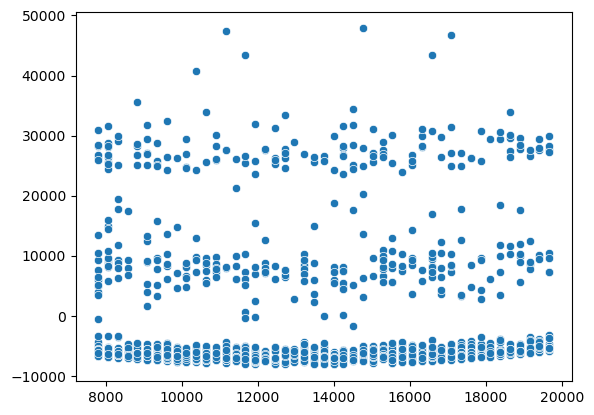

In [11]:
# Plot Residuals -- three tiers here to try to predict with new features

sns.scatterplot(x=model.predict(), y=model.resid)